## Bussiness case
#### Create a predictive model to forecast the Covid19 cases based on past cases for a specific country or region.

In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.available
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error

# interactive visualization
import plotly.express as px
import plotly.graph_objs as go
# import plotly.figure_factory as ff
from plotly.subplots import make_subplots

In [3]:
# read data from Johns Hopkins github repo
confirmed_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('time_series_covid19_recovered_global.csv')

In [4]:
# shape of dataframe
print(confirmed_df.shape)
print(deaths_df.shape)
print(recoveries_df.shape)

(266, 248)
(266, 248)
(253, 248)


In [5]:
# first 5 rows
confirmed_df.head()

Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  9/12/20  9/13/20  9/14/20  \
0        0        0        0        0  ...    38641    38716    38772   
1        0        0        0        0  ...    11185    11353    11520   
2        0        0        0        0  ...    48007    48254    48496   
3        0        0        0        0  ...     1344     1344     1438   
4        0        0        0        0  ...     3335     3388     3439   

   9/15/20  9/16/20  9/17/20  9/18/20  9/19/20  9/20/20  9/21/20  
0    38815    38855    38872    38883    38919    39044    39074  
1    11672    11816    11948    12073    12226    12385    12535  
2    48734    48966    49194    49413    49623    49826    50023  
3     1438     1483     1483     1564     1564     1564     1681  
4     3569     3675     3789     3848     3901     3991     4117  

[5 rows x 248 columns]

In [6]:
# checking null values
confirmed_df.isna().sum()

Province/State    185
Country/Region      0
Lat                 0
Long                0
1/22/20             0
                 ... 
9/17/20             0
9/18/20             0
9/19/20             0
9/20/20             0
9/21/20             0
Length: 248, dtype: int64

In [7]:
# check all unique values
confirmed_df.nunique()

Province/State     81
Country/Region    188
Lat               262
Long              263
1/22/20            11
                 ... 
9/17/20           258
9/18/20           260
9/19/20           258
9/20/20           257
9/21/20           255
Length: 248, dtype: int64

In [8]:
# check all unique values
recoveries_df.nunique()

Province/State     67
Country/Region    188
Lat               252
Long              252
1/22/20             2
                 ... 
9/17/20           241
9/18/20           242
9/19/20           242
9/20/20           242
9/21/20           241
Length: 248, dtype: int64

In [9]:
# value counts by country
confirmed_df['Country/Region'].value_counts()

China             33
Canada            14
United Kingdom    11
France            11
Australia          8
                  ..
Greece             1
Grenada            1
Guatemala          1
Guinea             1
Zimbabwe           1
Name: Country/Region, Length: 188, dtype: int64

### Cleaning :

#### 1) Rename columns 'Province/State' & 'Country/Region' & change latest date to 'Current'.

In [10]:
col=confirmed_df.columns[-1]

confirmed_df.rename(columns = {'Province/State' : 'Province', 'Country/Region' : 'Country', col : 'Current'},inplace = True)
deaths_df.rename(columns = {'Province/State' : 'Province', 'Country/Region' : 'Country', col : 'Current'},inplace = True)
recoveries_df.rename(columns = {'Province/State' : 'Province', 'Country/Region' : 'Country', col : 'Current'},inplace = True)
confirmed_df.head(1)

Province      Country       Lat       Long  1/22/20  1/23/20  1/24/20  \
0      NaN  Afghanistan  33.93911  67.709953        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  9/12/20  9/13/20  9/14/20  9/15/20  \
0        0        0        0  ...    38641    38716    38772    38815   

   9/16/20  9/17/20  9/18/20  9/19/20  9/20/20  Current  
0    38855    38872    38883    38919    39044    39074  

[1 rows x 248 columns]

#### 2) Make new dataframe grouping by unique country

In [11]:
# confirmed cases
confirm = pd.DataFrame(confirmed_df.groupby('Country').sum())
confirm.reset_index(inplace = True)
confirm.head(2)

Country       Lat       Long  1/22/20  1/23/20  1/24/20  1/25/20  \
0  Afghanistan  33.93911  67.709953        0        0        0        0   
1      Albania  41.15330  20.168300        0        0        0        0   

   1/26/20  1/27/20  1/28/20  ...  9/12/20  9/13/20  9/14/20  9/15/20  \
0        0        0        0  ...    38641    38716    38772    38815   
1        0        0        0  ...    11185    11353    11520    11672   

   9/16/20  9/17/20  9/18/20  9/19/20  9/20/20  Current  
0    38855    38872    38883    38919    39044    39074  
1    11816    11948    12073    12226    12385    12535  

[2 rows x 247 columns]

In [12]:
# drop Lat & Long columns as they do not give accurate results
col = confirm['Country']
confirm.drop(['Lat','Long'],axis=1,inplace=True)
confirm.head(2)

Country  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
0  Afghanistan        0        0        0        0        0        0        0   
1      Albania        0        0        0        0        0        0        0   

   1/29/20  1/30/20  ...  9/12/20  9/13/20  9/14/20  9/15/20  9/16/20  \
0        0        0  ...    38641    38716    38772    38815    38855   
1        0        0  ...    11185    11353    11520    11672    11816   

   9/17/20  9/18/20  9/19/20  9/20/20  Current  
0    38872    38883    38919    39044    39074  
1    11948    12073    12226    12385    12535  

[2 rows x 245 columns]

In [13]:
# deaths
deaths= pd.DataFrame(deaths_df.groupby('Country').sum())
deaths.reset_index(inplace = True)

# drop Lat & Long columns as they do not give accurate results
deaths.drop(['Lat','Long'],axis=1,inplace=True)
deaths.head(2)

Country  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
0  Afghanistan        0        0        0        0        0        0        0   
1      Albania        0        0        0        0        0        0        0   

   1/29/20  1/30/20  ...  9/12/20  9/13/20  9/14/20  9/15/20  9/16/20  \
0        0        0  ...     1420     1420     1425     1426     1436   
1        0        0  ...      330      334      338      340      343   

   9/17/20  9/18/20  9/19/20  9/20/20  Current  
0     1436     1437     1437     1441     1444  
1      347      353      358      362      364  

[2 rows x 245 columns]

In [14]:
# recovery
recovery= pd.DataFrame(recoveries_df.groupby('Country').sum())
recovery.reset_index(inplace = True)

# drop Lat & Long columns as they do not give accurate results
recovery.drop(['Lat','Long'],axis=1,inplace=True)
recovery.head(2)

Country  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
0  Afghanistan        0        0        0        0        0        0        0   
1      Albania        0        0        0        0        0        0        0   

   1/29/20  1/30/20  ...  9/12/20  9/13/20  9/14/20  9/15/20  9/16/20  \
0        0        0  ...    31234    31638    32073    32098    32503   
1        0        0  ...     6494     6569     6615     6668     6733   

   9/17/20  9/18/20  9/19/20  9/20/20  Current  
0    32505    32576    32576    32576    32576  
1     6788     6831     6888     6940     6995  

[2 rows x 245 columns]

#### 3) Create new dataframe for active cases

In [15]:
# active cases dataframe
active= confirm.copy()
for i in active.columns[1:]:
    active[i] =active[i] - recovery[i] - deaths[i]
active.head()

Country  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
0  Afghanistan        0        0        0        0        0        0        0   
1      Albania        0        0        0        0        0        0        0   
2      Algeria        0        0        0        0        0        0        0   
3      Andorra        0        0        0        0        0        0        0   
4       Angola        0        0        0        0        0        0        0   

   1/29/20  1/30/20  ...  9/12/20  9/13/20  9/14/20  9/15/20  9/16/20  \
0        0        0  ...     5987     5658     5274     5291     4916   
1        0        0  ...     4361     4450     4567     4664     4740   
2        0        0  ...    12527    12605    12672    12717    12804   
3        0        0  ...      348      348      440      440      376   
4        0        0  ...     1914     1953     1979     2098     2131   

   9/17/20  9/18/20  9/19/20  9/20/20  Current  
0     4931     4870     4906     5027     5054  
1     4813     4889     4980     5083     5176  
2    12865    12936    13035    13107    13164  
3      376      347      347      347      429  
4     2240     2258     2309     2394     2514  

[5 rows x 245 columns]

## Analysis :

### 1) Total Cases till date

In [16]:
print("Confirmed Cases :" , confirm.iloc[:,-1].sum())
print("Recovered Cases :" , recovery.iloc[:,-1].sum())
print("Deaths :" , deaths.iloc[:,-1].sum())
print("Active Cases :", active.iloc[:,-1].sum())

Confirmed Cases : 31245797
Recovered Cases : 21394593
Deaths : 963693
Active Cases : 8887511


### 2) Top 10 countries

In [17]:
confirm_data = confirm[['Country','Current']].sort_values('Current',ascending = False)
deaths_data = deaths[['Country','Current']].sort_values('Current',ascending = False)
recovery_data = recovery[['Country','Current']].sort_values('Current',ascending = False)
active_data = active[['Country','Current']].sort_values('Current',ascending = False)

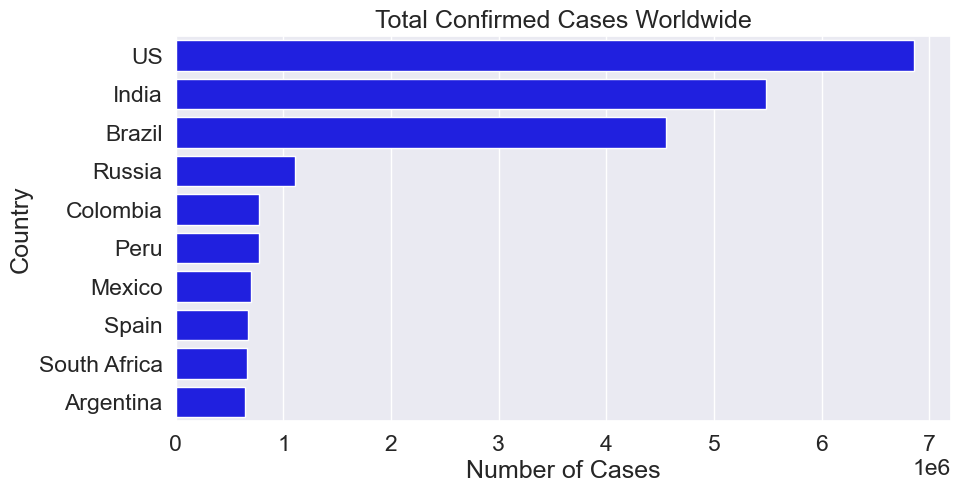

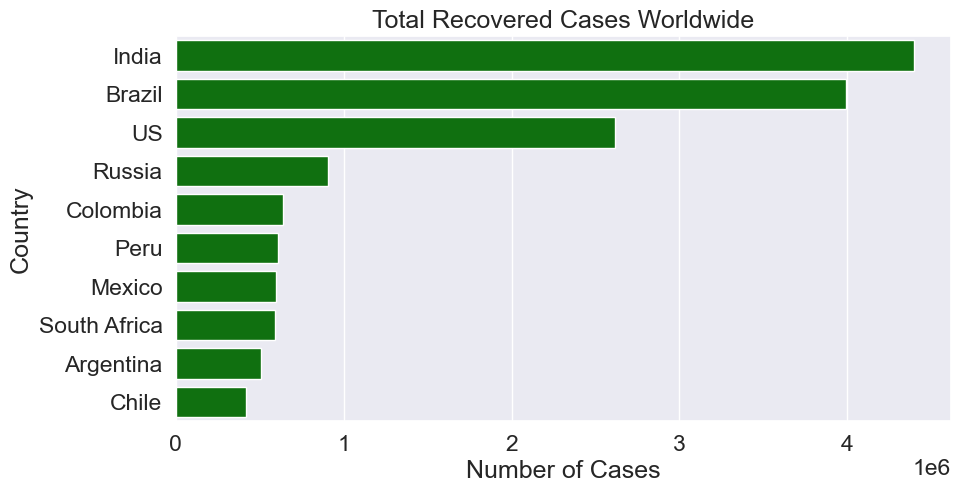

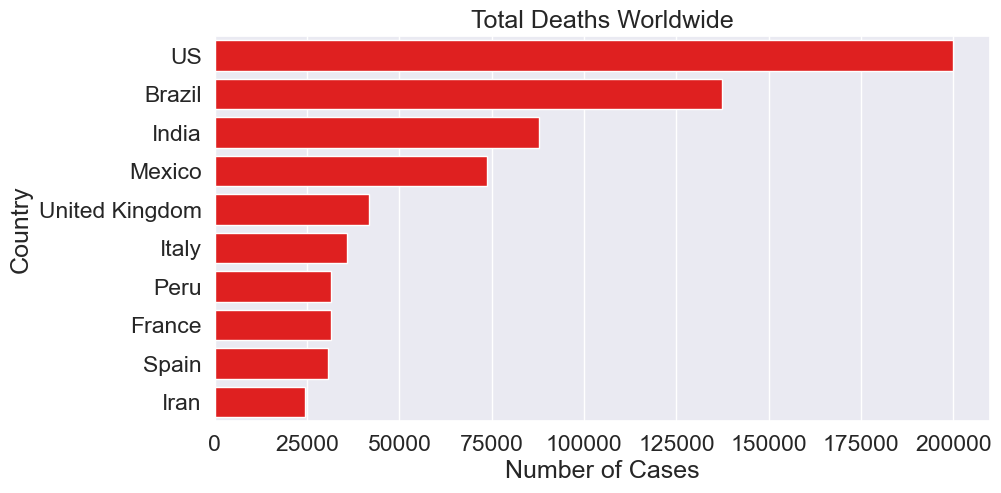

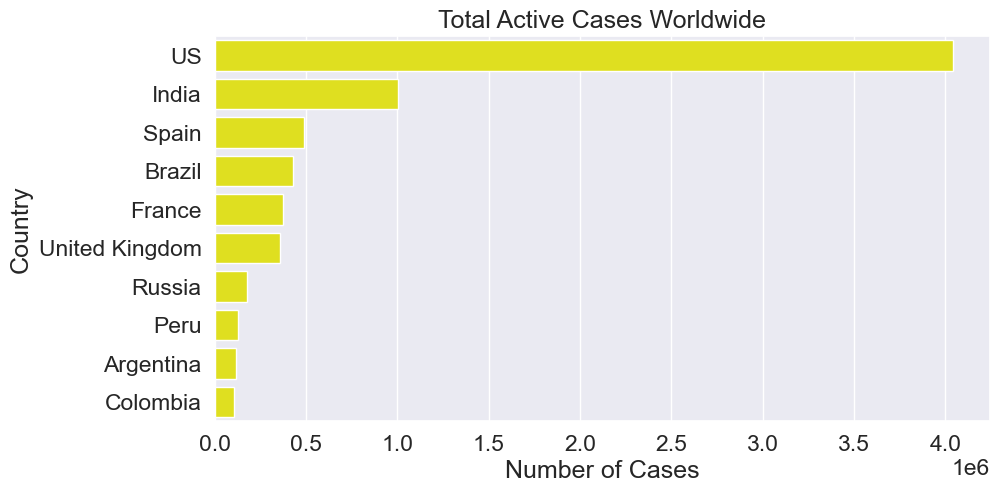

In [18]:
# Confirmed Cases
sns.set(font_scale=1.5)
plt.figure(figsize=(10,5))
fig= sns.barplot(x='Current', y='Country', data=confirm_data[:10], orient='h',color='Blue')
plt.title('Total Confirmed Cases Worldwide')
fig.set(xlabel ='Number of Cases', ylabel ='Country')
plt.show()

# Recovery Cases
plt.figure(figsize=(10,5))
fig= sns.barplot(x='Current', y='Country', data=recovery_data[:10], orient='h',color='Green')
plt.title('Total Recovered Cases Worldwide')
fig.set(xlabel ='Number of Cases', ylabel ='Country')
plt.show()

# Death Cases
plt.figure(figsize=(10,5))
fig= sns.barplot(x='Current', y='Country', data=deaths_data[:10], orient='h',color='Red')
plt.title('Total Deaths Worldwide')
fig.set(xlabel ='Number of Cases', ylabel ='Country')
plt.show()

# Active Cases
plt.figure(figsize=(10,5))
fig= sns.barplot(x='Current', y='Country', data=active_data[:10], orient='h',color='Yellow')
plt.title('Total Active Cases Worldwide')
fig.set(xlabel ='Number of Cases', ylabel ='Country')
plt.show()

### 3) Daily Cases for China, Italy, US, Russia, India, Brazil

In [19]:
china_confirm = confirm[confirm.Country == 'China'].iloc[:,1:].sum().values.tolist()
us_confirm = confirm[confirm.Country == 'US'].iloc[:,1:].sum().values.tolist()
italy_confirm = confirm[confirm.Country == 'Italy'].iloc[:,1:].sum().values.tolist()
india_confirm = confirm[confirm.Country == 'India'].iloc[:,1:].sum().values.tolist()
russia_confirm = confirm[confirm.Country == 'Russia'].iloc[:,1:].sum().values.tolist()
brazil_confirm = confirm[confirm.Country == 'Brazil'].iloc[:,1:].sum().values.tolist()

china_deaths = deaths[deaths.Country == 'China'].iloc[:,1:].sum().values.tolist()
us_deaths = deaths[deaths.Country == 'US'].iloc[:,1:].sum().values.tolist()
italy_deaths = deaths[deaths.Country == 'Italy'].iloc[:,1:].sum().values.tolist()
india_deaths = deaths[deaths.Country == 'India'].iloc[:,1:].sum().values.tolist()
russia_deaths = deaths[deaths.Country == 'Russia'].iloc[:,1:].sum().values.tolist()
brazil_deaths = deaths[confirm.Country == 'Brazil'].iloc[:,1:].sum().values.tolist()

china_recovery = recovery[recovery.Country == 'China'].iloc[:,1:].sum().values.tolist()
us_recovery = recovery[recovery.Country == 'US'].iloc[:,1:].sum().values.tolist()
italy_recovery = recovery[recovery.Country == 'Italy'].iloc[:,1:].sum().values.tolist()
india_recovery = recovery[recovery.Country == 'India'].iloc[:,1:].sum().values.tolist()
russia_recovery = recovery[recovery.Country == 'Russia'].iloc[:,1:].sum().values.tolist()
brazil_recovery = recovery[recovery.Country == 'Brazil'].iloc[:,1:].sum().values.tolist()

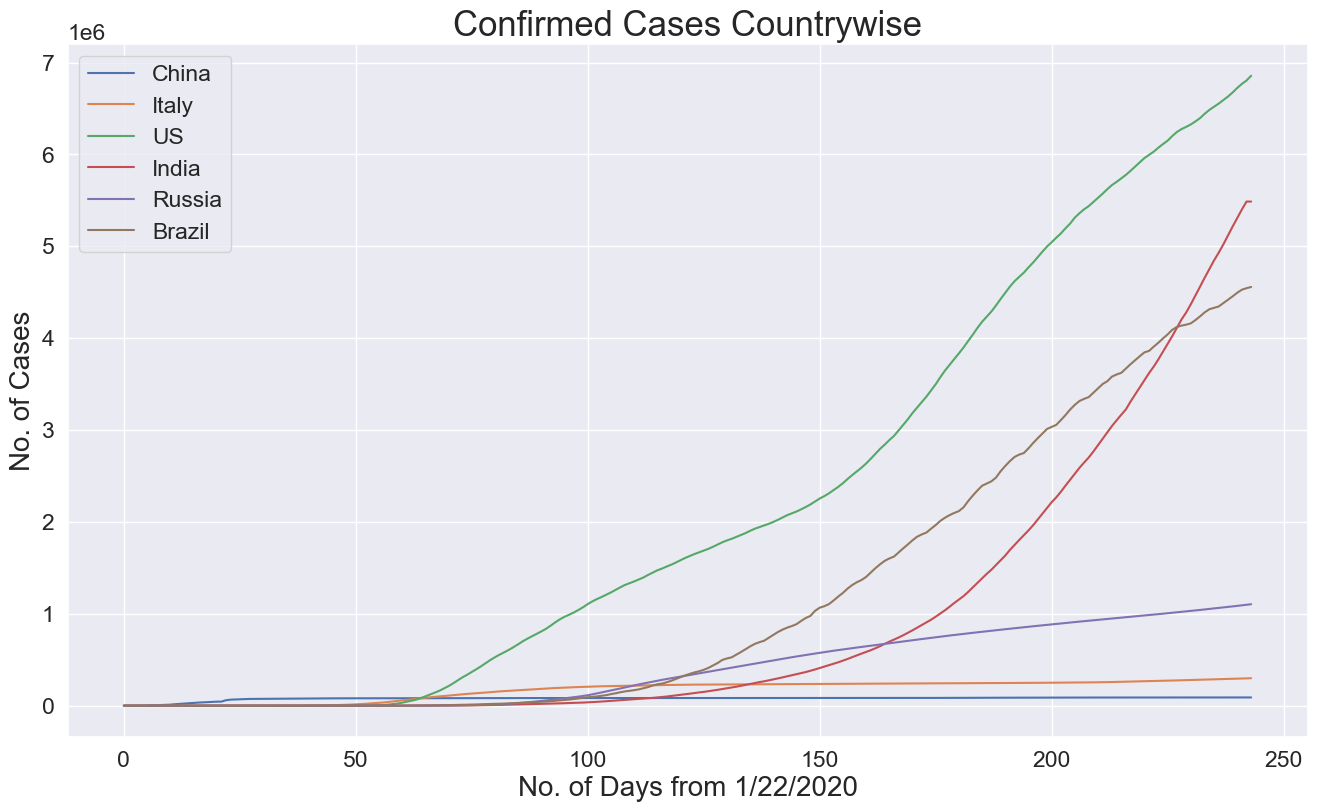

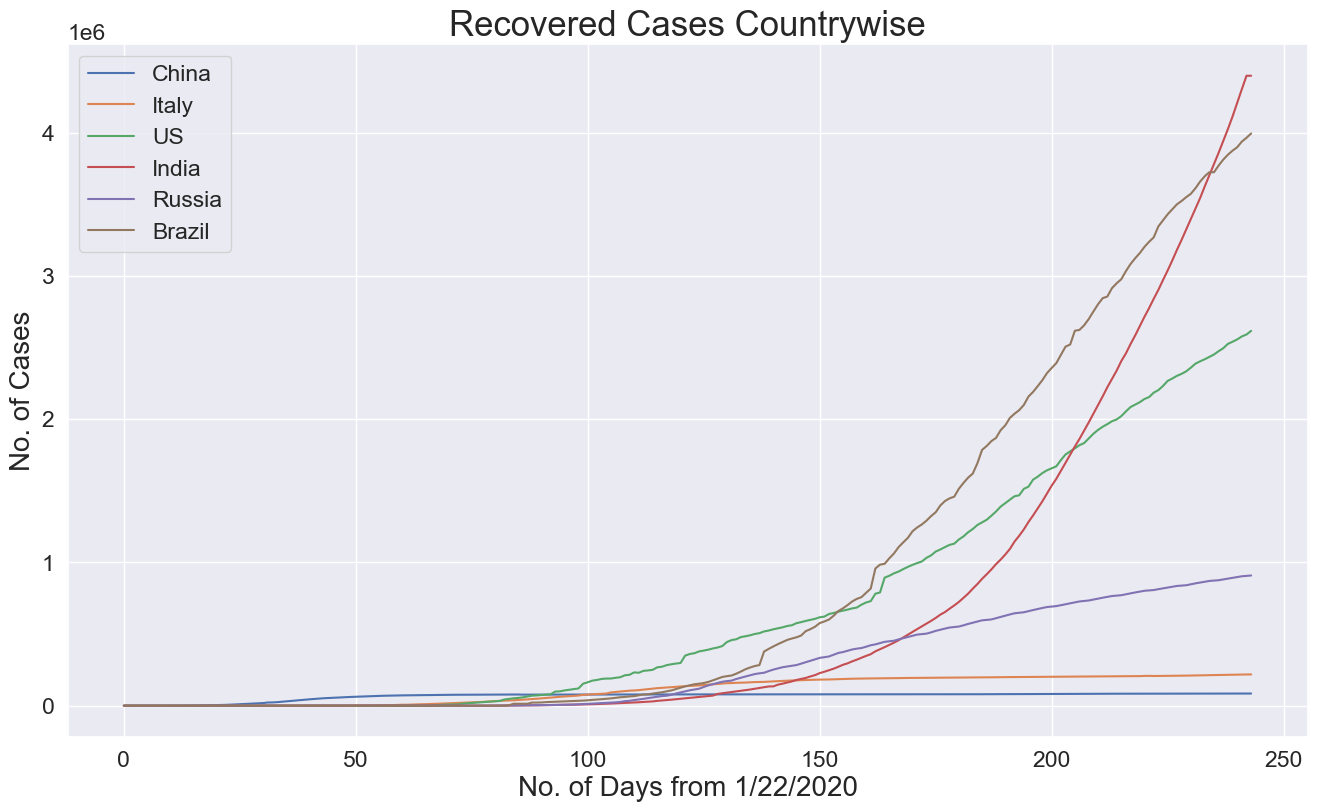

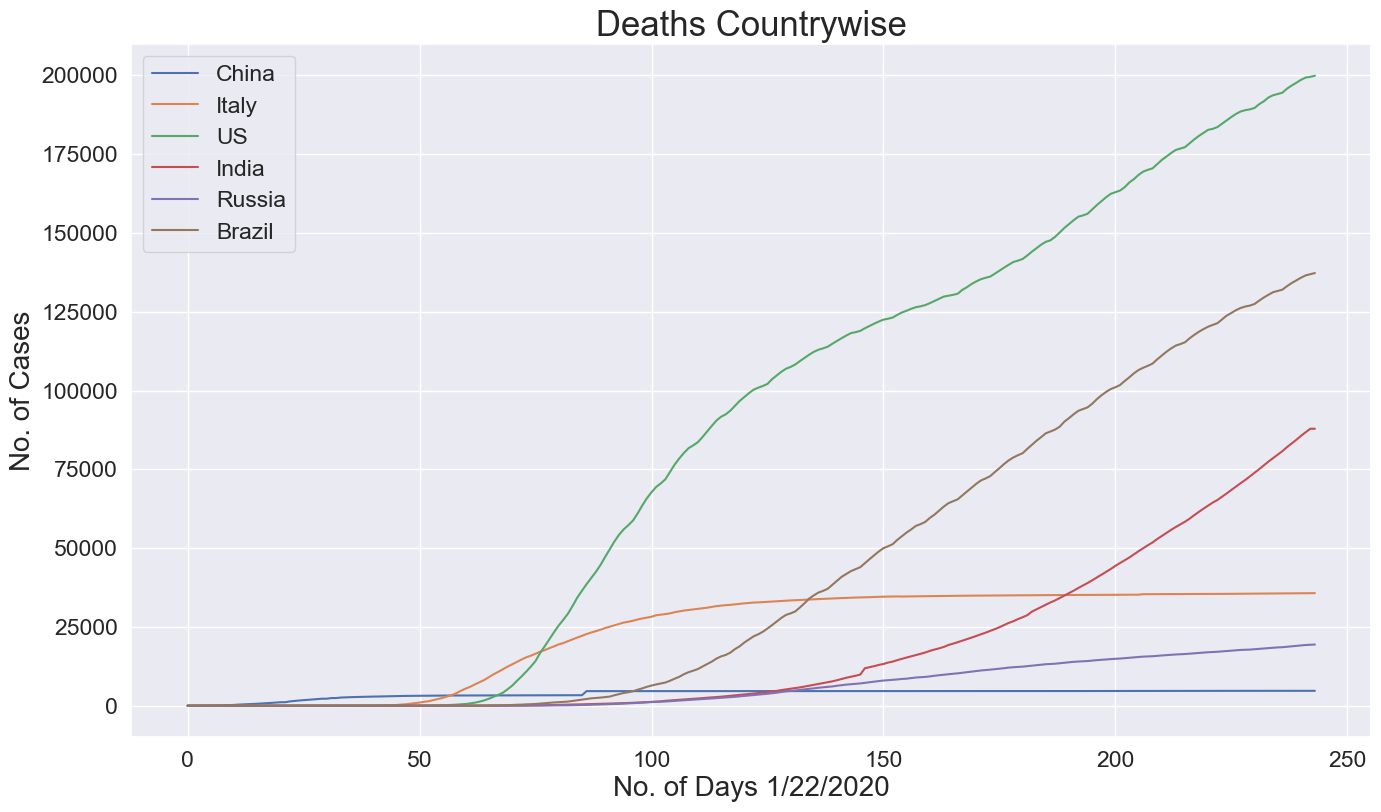

In [20]:
# Confirmed Cases
plt.figure(figsize=(16,9))
plt.plot(china_confirm)
plt.plot(italy_confirm)
plt.plot(us_confirm)
plt.plot(india_confirm)
plt.plot(russia_confirm)
plt.plot(brazil_confirm)

plt.title('Confirmed Cases Countrywise', size=25)
plt.xlabel('No. of Days from 1/22/2020', size=20)
plt.ylabel('No. of Cases', size=20)
plt.legend(['China', 'Italy','US','India','Russia','Brazil'])
plt.show()

# Recovered Cases
plt.figure(figsize=(16, 9))
plt.plot(china_recovery)
plt.plot(italy_recovery)
plt.plot(us_recovery)
plt.plot(india_recovery)
plt.plot(russia_recovery)
plt.plot(brazil_recovery)

plt.title('Recovered Cases Countrywise', size=25)
plt.xlabel('No. of Days from 1/22/2020', size=20)
plt.ylabel('No. of Cases', size=20)
plt.legend(['China', 'Italy','US','India','Russia','Brazil'])
plt.show()

# Deaths
plt.figure(figsize=(16, 9))
plt.plot(china_deaths)
plt.plot(italy_deaths)
plt.plot(us_deaths)
plt.plot(india_deaths)
plt.plot(russia_deaths)
plt.plot(brazil_deaths)

plt.title('Deaths Countrywise', size=25)
plt.xlabel('No. of Days 1/22/2020', size=20)
plt.ylabel('No. of Cases', size=20)
plt.legend(['China', 'Italy','US','India','Russia','Brazil'])
plt.show()

### 4) Increase in Cases Worldwide from 22/1/20

In [21]:
confirm_date = confirm.iloc[:,1:].sum().values.tolist()
recovery_date = recovery.iloc[:,1:].sum().values.tolist()
deaths_date = deaths.iloc[:,1:].sum().values.tolist()
active_date = active.iloc[:,1:].sum().values.tolist()

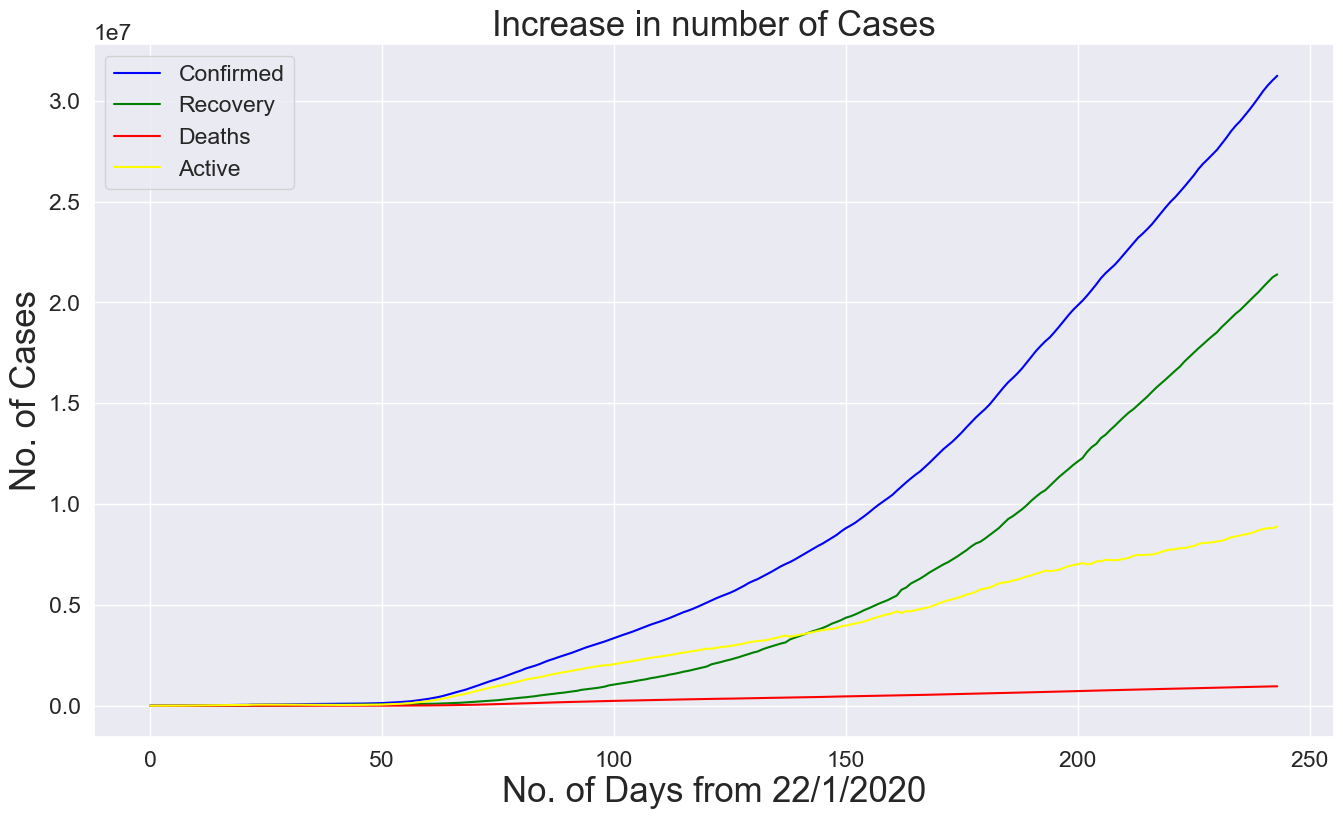

In [22]:
plt.figure(figsize=(16,9))
plt.plot(confirm_date,color='Blue')
plt.plot(recovery_date,color='Green')
plt.plot(deaths_date,color='Red')
plt.plot(active_date,color='Yellow')

plt.xlabel('No. of Days from 22/1/2020',size=25)
plt.ylabel('No. of Cases',size=25)
plt.title('Increase in number of Cases',size=25)
plt.legend(['Confirmed','Recovery','Deaths','Active'])
plt.show()

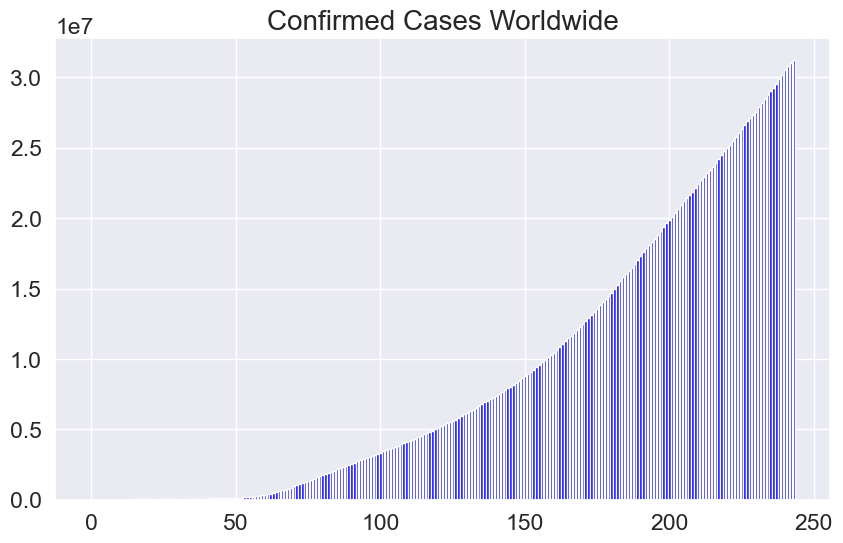

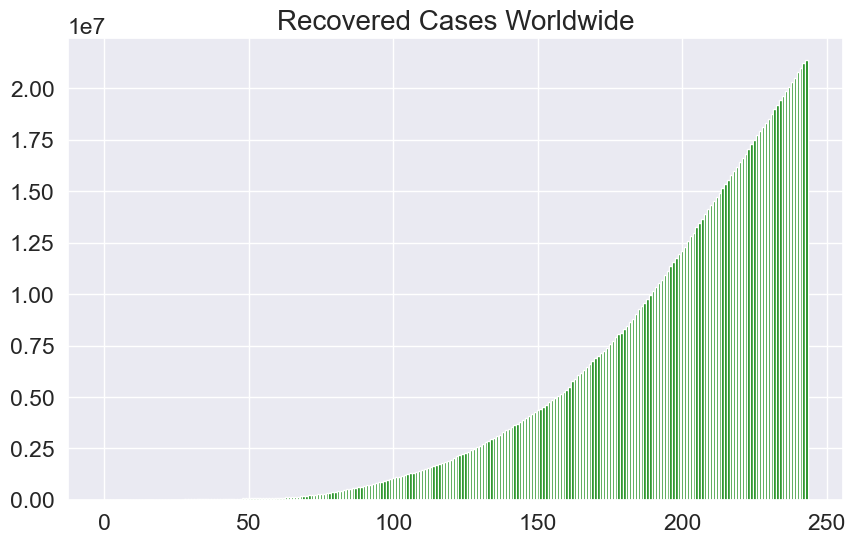

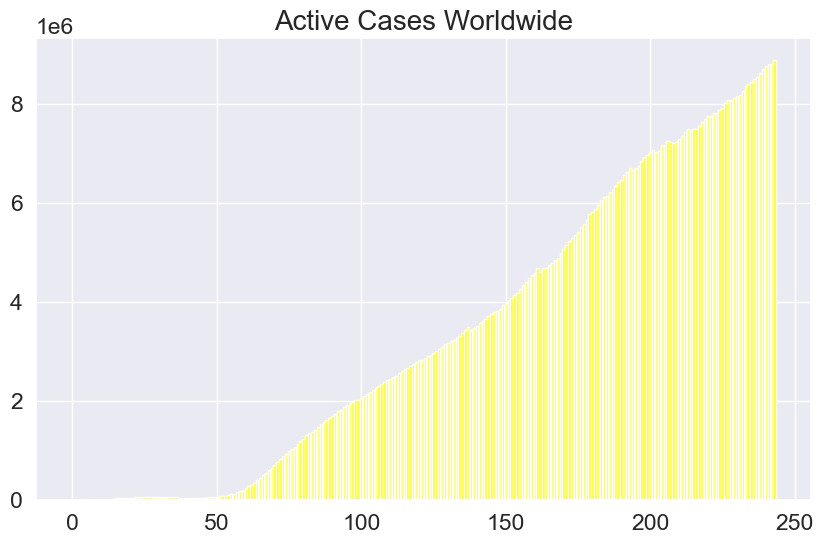

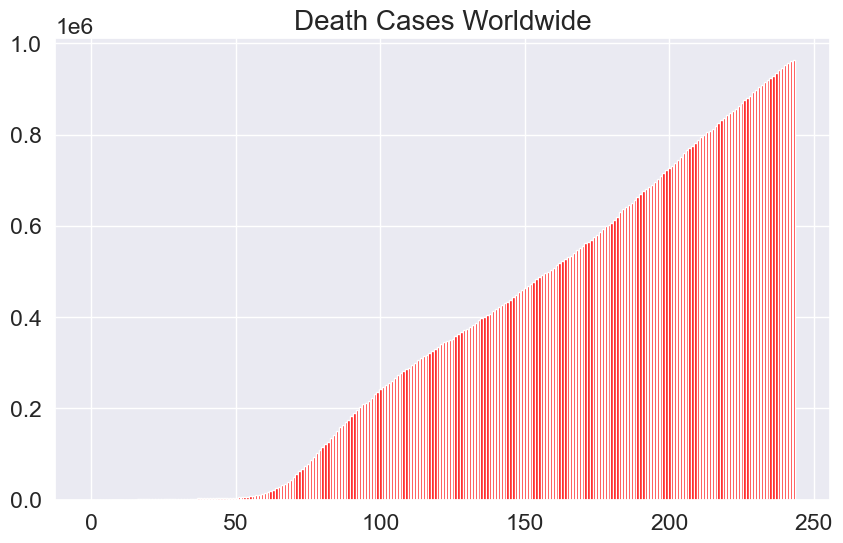

In [23]:
days = [ i for i in range(confirm.shape[1] - 1) ] 

plt.figure(figsize=(10,6))
plt.bar(days,confirm_date,color='Blue')
plt.title('Confirmed Cases Worldwide',size=20)
plt.show()

plt.figure(figsize=(10,6))
plt.bar(days,recovery_date,color='Green')
plt.title('Recovered Cases Worldwide',size=20)
plt.show()

plt.figure(figsize=(10,6))
plt.bar(days,active_date,color='Yellow')
plt.title('Active Cases Worldwide',size=20)
plt.show()

plt.figure(figsize=(10,6))
plt.bar(days,deaths_date,color='Red')
plt.title('Death Cases Worldwide',size=20)
plt.show()

### 5) Global Cases Distribution :

In [24]:
# Confirmed Cases
fig = px.choropleth(confirm_data, locations="Country", locationmode='country names', 
                  color=confirm_data['Current'], hover_name="Country", 
                  title='Countries with Confirmed Cases',hover_data=['Current'], color_continuous_scale="blues")
fig.show()

# Recovered Cases
fig = px.choropleth(recovery_data, locations="Country", locationmode='country names', 
                  color=recovery_data['Current'], hover_name="Country", 
                  title='Countries with Recovered Cases',hover_data=['Current'], color_continuous_scale="emrld")
fig.show()

# Death Cases
fig = px.choropleth(deaths_data, locations="Country", locationmode='country names', 
                  color=deaths_data['Current'], hover_name="Country", 
                  title='Countries with Death Cases',hover_data=['Current'], color_continuous_scale="peach")
fig.show()

# Active Cases
fig = px.choropleth(active_data, locations="Country", locationmode='country names', 
                  color=active_data['Current'], hover_name="Country", 
                  title='Countries with Active Cases',hover_data=['Current'], color_continuous_scale="ylgn")
fig.show()


## Linear Regression :

In [25]:
total_confirm = np.array(confirm_date).reshape(-1,1)
total_deaths = np.array(deaths_date).reshape(-1,1)
total_recovery = np.array(recovery_date).reshape(-1,1)
total_active = np.array(active_date).reshape(-1,1)
dates = np.array([i for i in range(len(days))]).reshape(-1, 1)

In [26]:
# Visualization function
def linear_plot(x,y,reg,title):
    plt.figure(figsize=(10,6)) 
    plt.scatter(x,y,color='red')
    plt.plot(x,reg)
    plt.title(title)

In [27]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(dates[50:], total_confirm[50:], test_size=0.14, shuffle=False)

In [28]:
reg = LinearRegression()
reg.fit(X_train_confirmed, y_train_confirmed);

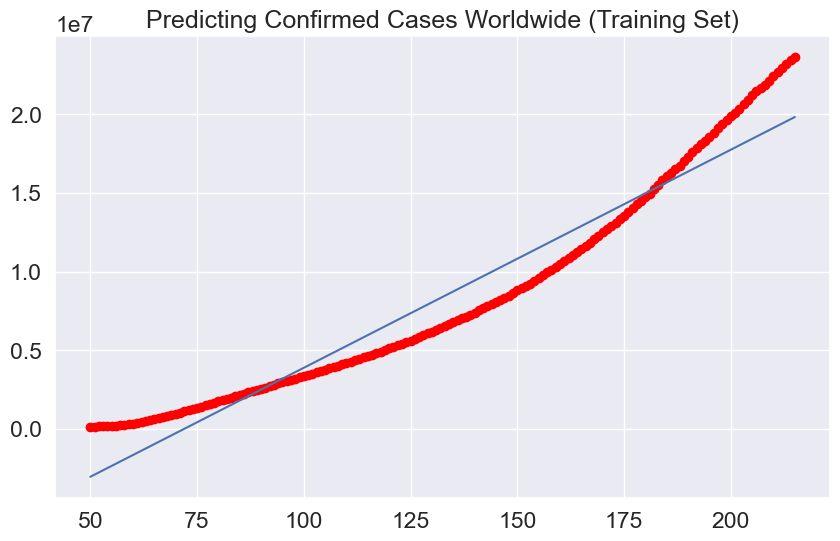

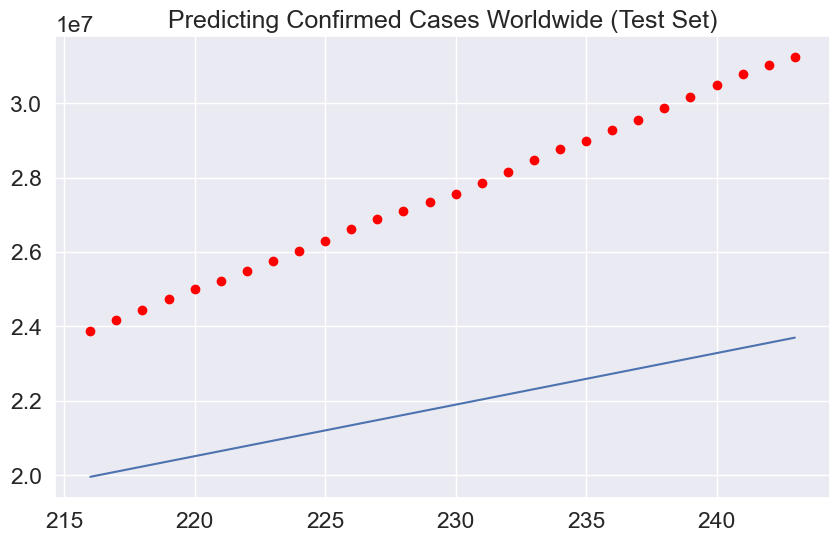

In [29]:
# Plot training set
linear_plot(X_train_confirmed,y_train_confirmed,reg.predict(X_train_confirmed),'Predicting Confirmed Cases Worldwide (Training Set)')

# Plot test set
linear_plot(X_test_confirmed,y_test_confirmed,reg.predict(X_test_confirmed),'Predicting Confirmed Cases Worldwide (Test Set)')


## Polynomial Linear Regression

### Confirmed Cases

In [32]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
 # transform our data for polynomial regression
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)

In [34]:
# polynomial regression
poly_reg = LinearRegression(normalize=True, fit_intercept=False)
poly_reg.fit(poly_X_train_confirmed, y_train_confirmed)

LinearRegression(fit_intercept=False, normalize=True)

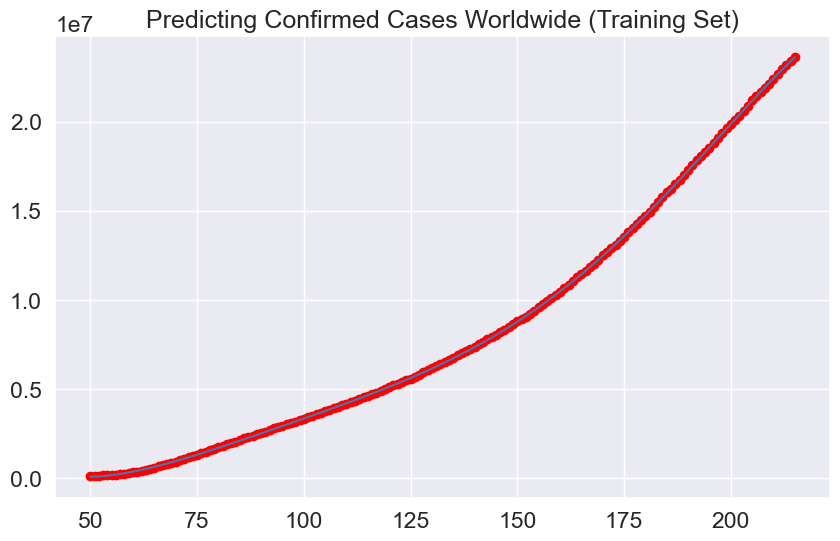

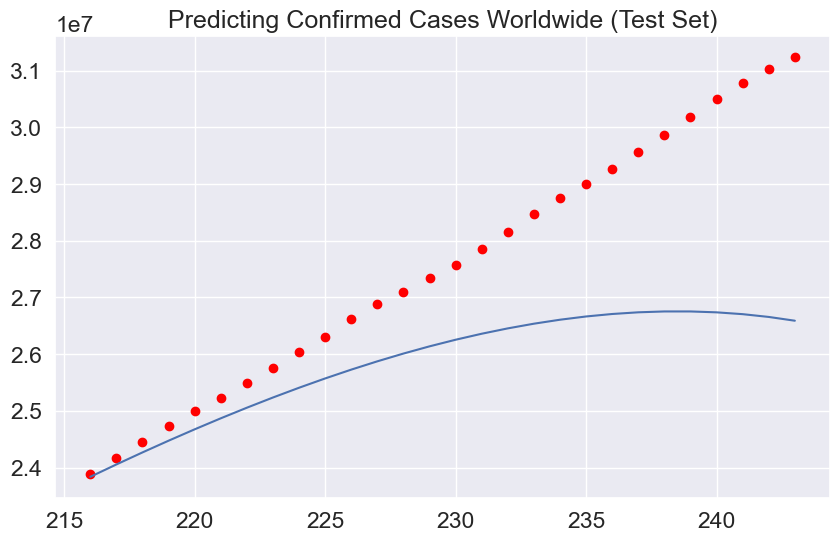

In [35]:
# Plot training set
linear_plot(X_train_confirmed,y_train_confirmed,poly_reg.predict(poly_X_train_confirmed),'Predicting Confirmed Cases Worldwide (Training Set)')

# Plot test set
linear_plot(X_test_confirmed,y_test_confirmed,poly_reg.predict(poly_X_test_confirmed),'Predicting Confirmed Cases Worldwide (Test Set)')

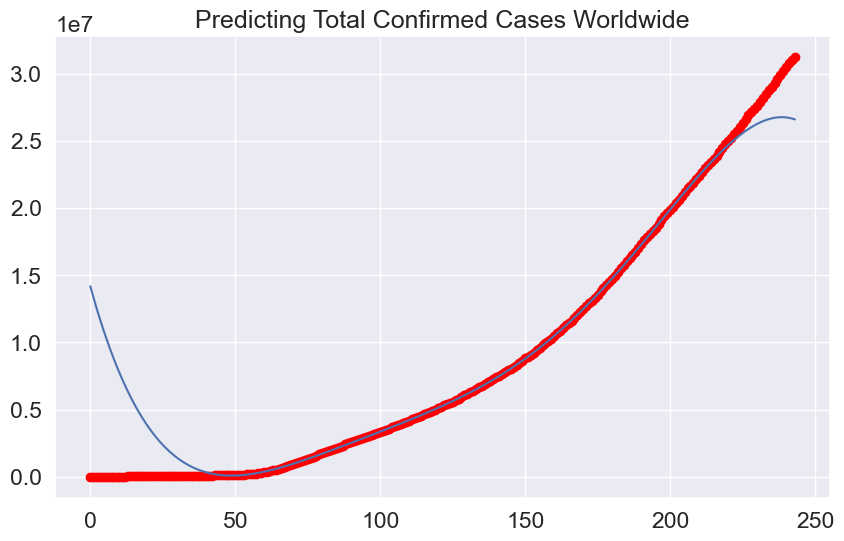

In [36]:
# Plot total cases
linear_plot(dates,total_confirm,poly_reg.predict(poly.fit_transform(dates)),'Predicting Total Confirmed Cases Worldwide')

## Death Cases 

In [37]:
X_train_deaths, X_test_deaths, y_train_deaths, y_test_deaths = train_test_split(dates[60:], total_deaths[60:], test_size=0.14, shuffle=False) 

In [38]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=5)
poly_X_train_deaths = poly.fit_transform(X_train_deaths)
poly_X_test_deaths = poly.fit_transform(X_test_deaths)

# polynomial regression
poly_reg = LinearRegression(normalize=True, fit_intercept=False)
poly_reg.fit(poly_X_train_deaths, y_train_deaths)

LinearRegression(fit_intercept=False, normalize=True)

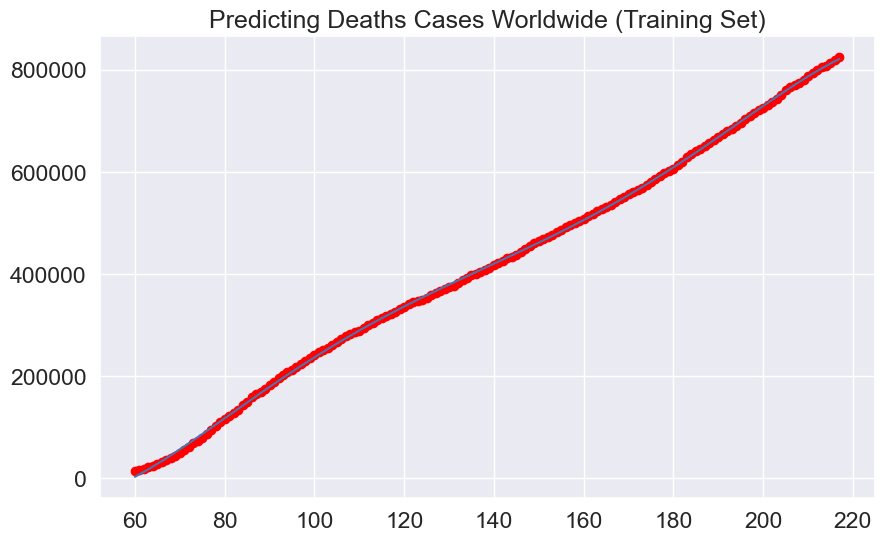

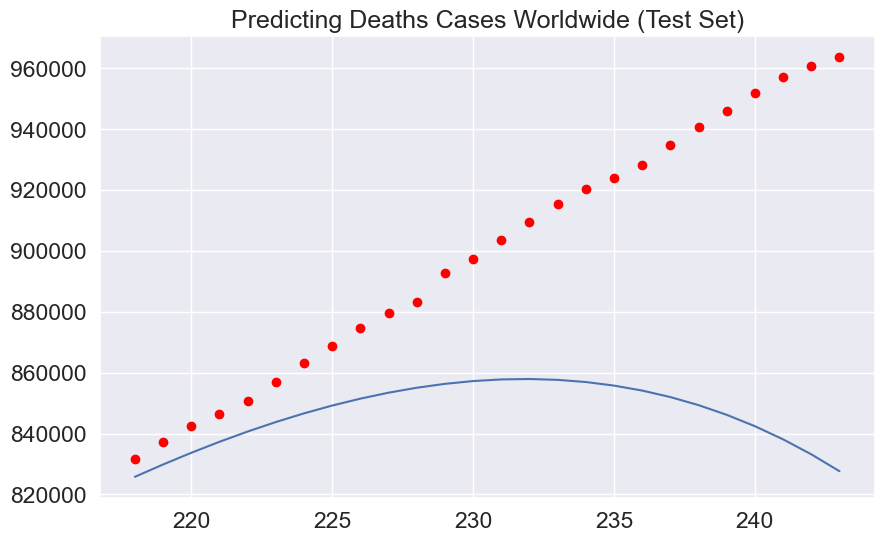

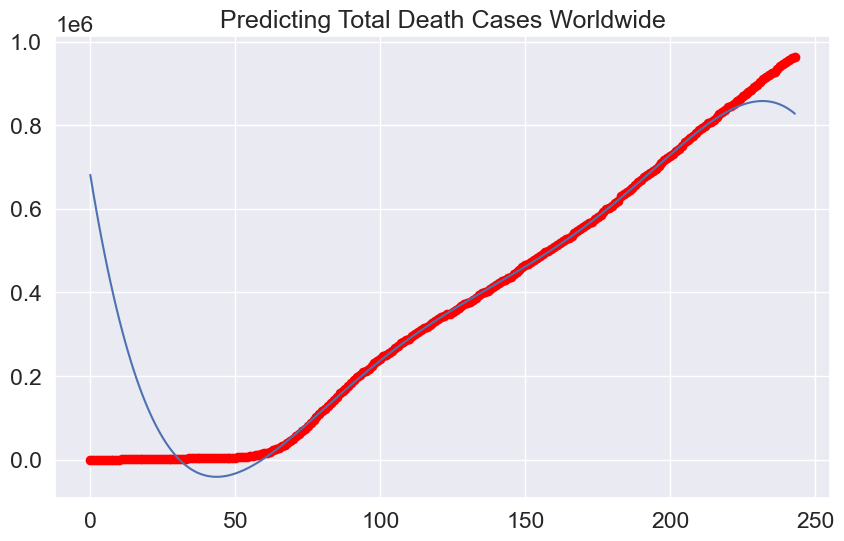

In [39]:
# Plot training set
linear_plot(X_train_deaths,y_train_deaths,poly_reg.predict(poly_X_train_deaths),'Predicting Deaths Cases Worldwide (Training Set)')

# Plot test set
linear_plot(X_test_deaths,y_test_deaths,poly_reg.predict(poly_X_test_deaths),'Predicting Deaths Cases Worldwide (Test Set)')

# Plot total cases
linear_plot(dates,total_deaths,poly_reg.predict(poly.fit_transform(dates)),'Predicting Total Death Cases Worldwide')